# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make conclusions) then **text answer** is **mandatory** and **is** part of the task
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 

In [ ]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model is parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{\exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{lenght(y)}  \frac{y}{\exp(y*(Xw+w_0)))}$$

##### Put your markdown formulas here below:

**Reminder!**
Do not use loops in task 2 and task 3. Loss and grad functions should be implemented in matrix form, without loops.

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [ ]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    
    """
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    """
    return np.log(1 + np.exp(-y * (np.dot(X, w) + w0))).reshape(-1, 1).mean(axis = 0) + np.sum(gamma * np.abs(w) + beta * w * w)

#### 3. [0.5 points] Implement the gradient (as a function)

In [ ]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    '''
    grad_w = -((X * y.reshape(-1, 1)) / (1 + np.exp(y * (np.dot(X, w) + w0))).reshape(-1, 1)).mean(axis = 0) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = -((y.reshape(-1, 1)) / (1 + np.exp(y * (np.dot(X, w) + w0))).reshape(-1, 1)).mean(axis = 0)
    return (grad_w, grad_w0)

#### Check yourself

In [ ]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):  
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge
        
        '''
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
  
        # you may additional properties if you wish
        
        
    def fit(self, X, y):
        
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        self.w = np.zeros(X.shape[1])
        self.w0 = 0
        self.loss_history = [loss(X, y, self.w, self.w0, self.gamma, self.beta)]
        
        for i in range(self.max_iter):
          grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
          check_grad = np.append(grad_w, grad_w0)

          if(np.sqrt(np.dot(check_grad, check_grad)) < self.tolerance):
            break
          
          self.w -= self.learning_rate * grad_w
          self.w0 -= self.learning_rate * grad_w0
          self.loss_history.append(loss(X, y, self.w, self.w0, self.gamma, self.beta))
     
    
    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X
        
        '''
        pred = np.dot(X, self.w) + self.w0
        return np.where(pred > 0, 1, 0)
            

    def predict_proba(self, X):
        '''
        Function that estimates probabilities 

        '''
        return 1 / (1 + np.exp(-(np.dot(X, self.w) + self.w0)))

In [ ]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [ ]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

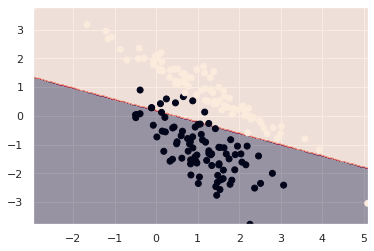

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

Text(0, 0.5, 'loss function')

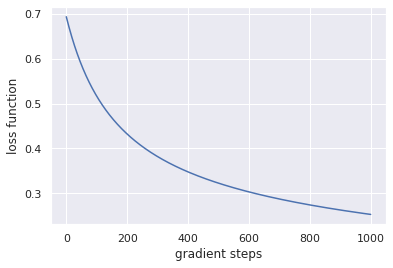

In [ ]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel('gradient steps')
plt.ylabel('loss function')

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

0.983050847457627


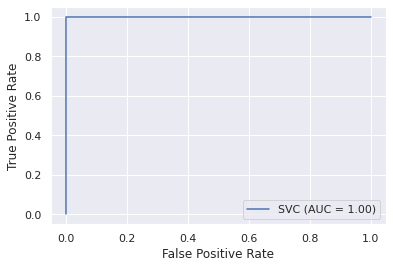

In [ ]:
#Try linear svm
linear1 = SVC(kernel = 'linear', gamma = 'scale')
linear1.fit(X_train, y_train)
plot_roc_curve(linear1, X_test, y_test)
print(f1_score(y_test, linear1.predict(X_test)))

Test poly svm with degree =  1


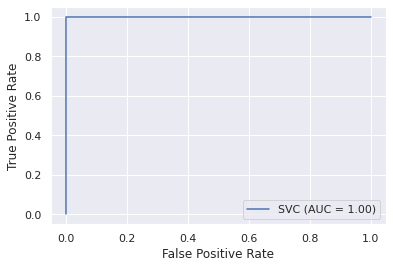

f1 score =  0.983050847457627
Test poly svm with degree =  2


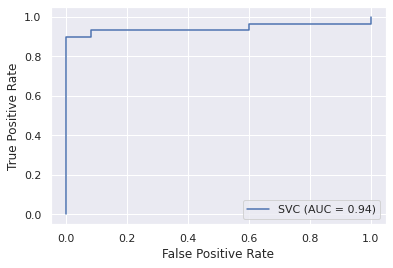

f1 score =  0.9454545454545454
Test poly svm with degree =  3


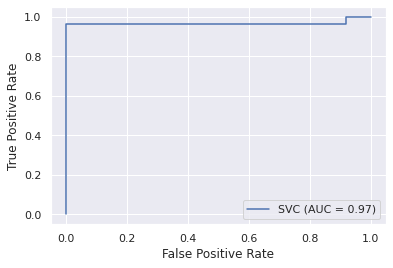

f1 score =  0.9824561403508771
Test poly svm with degree =  4


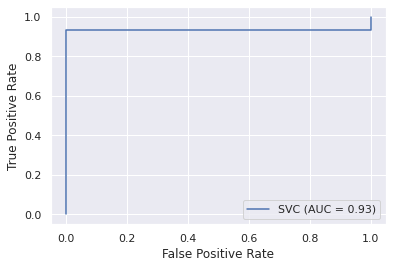

f1 score =  0.8627450980392156
Test poly svm with degree =  5


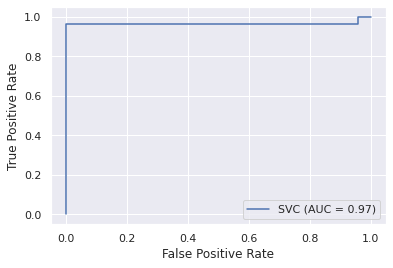

f1 score =  0.9056603773584906
Test poly svm with degree =  6


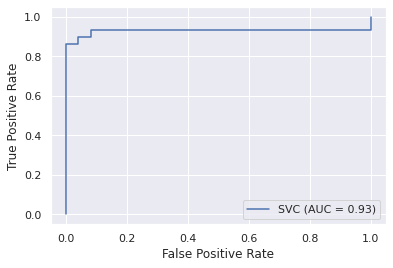

f1 score =  0.8163265306122449
Test poly svm with degree =  7


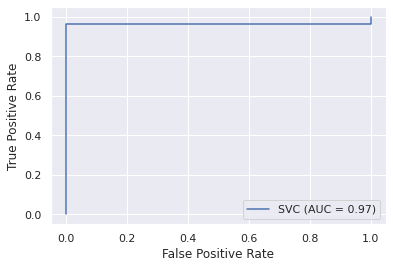

f1 score =  0.8846153846153846
Test poly svm with degree =  8


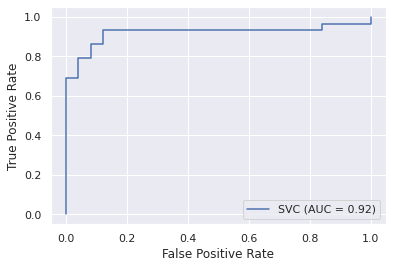

f1 score =  0.7391304347826086
Test poly svm with degree =  9


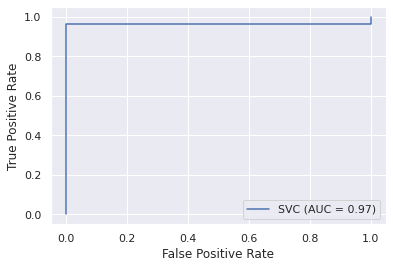

f1 score =  0.8846153846153846
Test poly svm with degree =  10


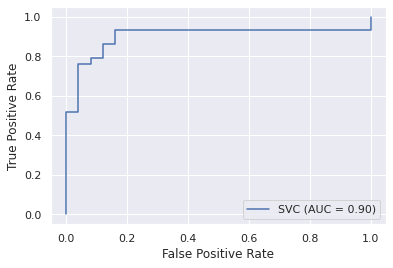

f1 score =  0.6956521739130435


In [ ]:
for i in range(10):
  print("Test poly svm with degree = ", i + 1)
  poly = SVC(kernel = 'poly', degree = i + 1)
  poly.fit(X_train, y_train)
  plot_roc_curve(poly, X_test, y_test)
  plt.show()
  print("f1 score = ", f1_score(y_test, poly.predict(X_test)))

0.983050847457627
0.983050847457627


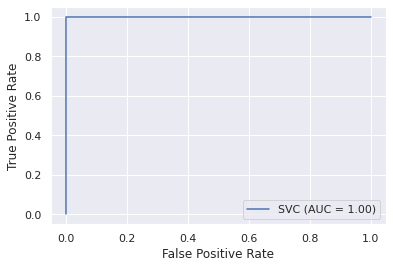

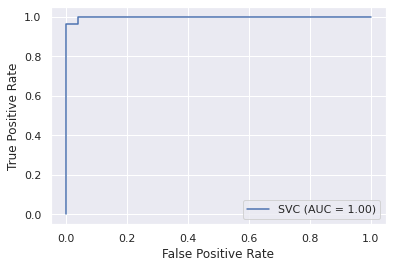

In [ ]:
rbf = SVC(kernel = 'rbf', gamma = 'auto')
rbf.fit(X_train, y_train)
plot_roc_curve(rbf, X_test, y_test)
print(f1_score(y_test, rbf.predict(X_test)))

rbf = SVC(kernel = 'rbf', gamma = 'scale')
rbf.fit(X_train, y_train)
plot_roc_curve(rbf, X_test, y_test)
print(f1_score(y_test, rbf.predict(X_test)))

In [20]:
#find the best params using GridSerchCv
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf', 'poly'), 'degree': range(11), 'coef0': np.arange(-5, 5, 0.1), 'gamma' : np.arange(0.1, 0.5, 0.05) }
svc = SVC()
clf = GridSearchCV(svc, parameters, cv = 5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'coef0': array([-5.00000000e+00, -4.9000000...
        3.80000000e+00,  3.90000000e+00,  4.00000000e+00,  4.10000000e+00,
        4.20000000e+00,  4.30000000e+00,  4.40000000e+00,  4.50000000e+00,
        4.60000000e+00,  4.70000000e+00,  4.80000000e+00,  4.90000000e+00]),
                         'degree': range(0, 11),
                         'gamma': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
                         'kernel': ('linear', 'rbf', 'poly')},
             pre_disp

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.29999999999998117, decision_function_shape='ovr', degree=3,
    gamma=0.45000000000000007, kernel='poly', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
1.0


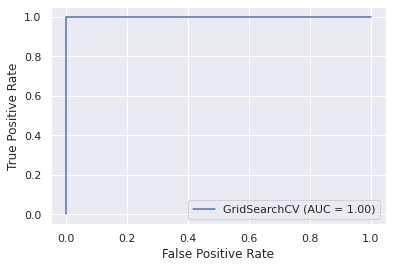

In [21]:
print(clf.best_estimator_)
plot_roc_curve(clf, X_test, y_test)
print(f1_score(y_test, clf.predict(X_test)))

Самый лучший результат показал SVM с полиномиальным ядром и также по данным исследованиям он переобучается сильнее SVM с линейным и RBF ядрами. Для полиномиального ядра нужно подбирать гиперпараметры такие как степень и coef0. Этот тип SVM очень чувствителен к их выбору. 
Линейное ядро не нуждается в особом подборе гиперпараметров и показывает хороший результат на тесте.
RBF ядро имеет всего один гиперпараметр (гамма) и показывает результат сравнимый с линейным ядром.


## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: [0.5 point]
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset  [1.5 point]
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [ ]:
# your code here

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. [1 point]
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. [1 point]
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

**HINT:** In the task 8.2 you should analyze models for binary classification task. How do you think the AUC_ROC should be high? Is the 0.6 enough for us?

In [ ]:
# your code here

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

In [ ]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score). **HINT:** Do not forget about set jobs=-1 in the GridSearchCV init to speed up calculations.
* make conclusions about the model

In [ ]:
# your code here